## Derivative 

In [128]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [129]:
#Define a ramdom polynomial 
def f(x):
    return 3*x**2 -4*x + 5
f(3.0)

20.0

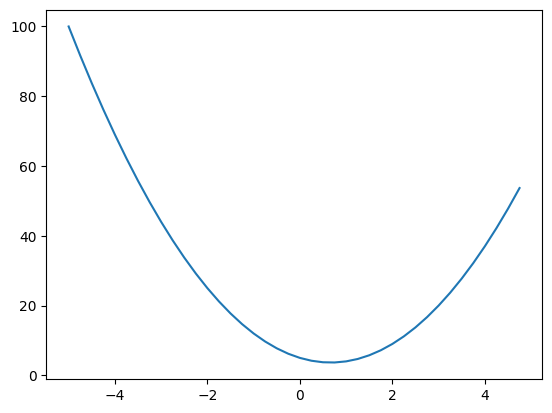

In [130]:
xs = np.arange(-5, 5, 0.25)

#pass the entire numpy array to the polynomial function
ys = f(xs)

plt.plot(xs, ys)

In [131]:
h = 0.000000001
x = 2/3.0
(f(x + h) - f(x)) / h

0.0

In [132]:
# lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [133]:
h = 0.000000001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c
print("d1: ", d1, "\nd2: ", d2)
print('slope', (d2 - d1) / h)
#How much the function changes, when we bump "a" by a tiny amount(h), then normalized with "h" 

d1:  4.0 
d2:  4.000000002
slope 2.000000165480742


## Neural Networks

In [184]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)
  
  def __rsub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [135]:
a = Value(2.0)
b = Value(4.0)
a.exp()

Value(data=7.38905609893065)

### Visualization Helper Functions

In [136]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [137]:
'''
Local derivative:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0

dd / dc  = ?
d = c + e
(f(x+h) - f(x)) / h

((c + e + h) - (e + e)) / h = 1.0

According to above, dd/ de = 1.0 also.

Now, we want dL / dc
which  = dL/dd * dd/dc = -2.0 * 1.0 = -2.0

c.grad = -2.0
e.grad = -2.0

a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0
'''

'\nLocal derivative:\nL.grad = 1.0\nf.grad = 4.0\nd.grad = -2.0\n\ndd / dc  = ?\nd = c + e\n(f(x+h) - f(x)) / h\n\n((c + e + h) - (e + e)) / h = 1.0\n\nAccording to above, dd/ de = 1.0 also.\n\nNow, we want dL / dc\nwhich  = dL/dd * dd/dc = -2.0 * 1.0 = -2.0\n\nc.grad = -2.0\ne.grad = -2.0\n\na.grad = -2.0 * -3.0\nb.grad = -2.0 * 2.0\n'

In [140]:
'''
a.data  += 0.01 * a.grad
b.data  += 0.01 * b.grad
c.data  += 0.01 * c.grad
f.data  += 0.01 * f.grad

e = a * b
e.label = 'e'
#(a.__mul__(b)).__add__(c)
d = e  + c; d.label = 'd'
L = d * f; L.label = 'L'
L
'''

AttributeError: 'float' object has no attribute 'data'

In [ ]:
def lol(h):
    a = Value(2.0, label = "a")
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a * b
    e.label = 'e'
    d = e  + c; d.label = 'd'
    f = Value(-2.0, label= 'f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label = "a")
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    a.data += h
    e = a * b
    e.label = 'e'
    #(a.__mul__(b)).__add__(c)
    d = e + c; d.label = 'd'
    f = Value(-2.0, label= 'f')
    L = d * f; L.label = 'L'
    L2 = L.data

    #How much L change if a is changed by h? (then normalized by h)
    print ((L2 - L1) / h)

lol(0.00001)



6.000000000128124


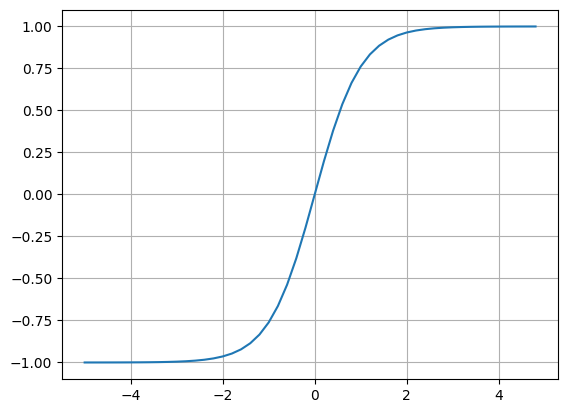

In [ ]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

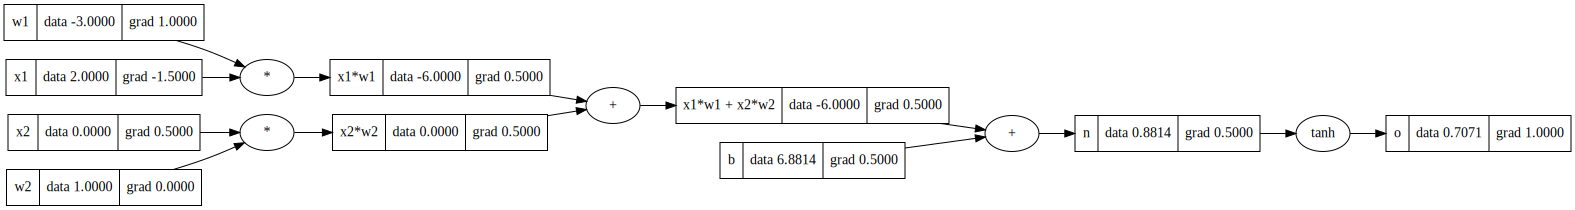

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

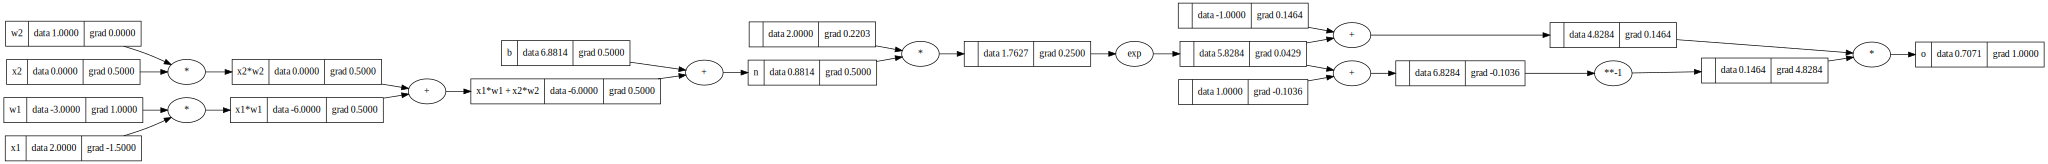

In [139]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ---- 
o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
'''
o = tanh(n)
do/dn = 1 - tanh(n)**2

 
n.grad = 1 - o.data ** 2
x1w1x2w2.grad = n.grad
b.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
= o.backward()
'''

## Doing the same task with PyTorch

In [149]:
import torch
import random

In [145]:
print(torch.Tensor([2.0]).dtype)
print(torch.Tensor([2.0]).double().dtype)

torch.float32
torch.float64


In [148]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(type(o.data))
print(type(o.data.item()))
print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

<class 'torch.Tensor'>
<class 'float'>
0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [348]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)),  self.b)
        out = act.tanh()
        return out
    def parameters(self):
       return self.w + [self.b]
class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron (nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
  
class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


Value(data=-0.8358242701809276)

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

In [346]:
len(n.parameters())

41

In [349]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [350]:
for k in range(20):
    ypred = [n(x) for x in xs]
    #ygt - y ground truth; yout - y out, prediction
    loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])

    #zero grad, clear all the prev gradients
    for p in n.parameters():
        p.grad = 0.0

    #back propagation  
    loss.backward()

    for p in n.parameters():
        p.data += -0.05 * p.grad
    print(k, loss)

0 Value(data=7.337260100737668)
1 Value(data=5.521600776093816)
2 Value(data=2.819194804827214)
3 Value(data=2.555716580505888)
4 Value(data=2.4325261669533926)
5 Value(data=2.3034875621298987)
6 Value(data=2.125713136047585)
7 Value(data=1.8577303005056882)
8 Value(data=1.4698055458584314)
9 Value(data=1.00600217927399)
10 Value(data=0.6009855380360577)
11 Value(data=0.35035262130230804)
12 Value(data=0.2228568930515646)
13 Value(data=0.15619925859167397)
14 Value(data=0.11761332393005)
15 Value(data=0.09315696257147853)
16 Value(data=0.07653808717842682)
17 Value(data=0.06462913037601062)
18 Value(data=0.05573613811903369)
19 Value(data=0.048874643479077585)


In [351]:
ypred

[Value(data=0.9097599769683511),
 Value(data=-0.9882510257394345),
 Value(data=-0.8606283342472435),
 Value(data=0.8545047007238669)]

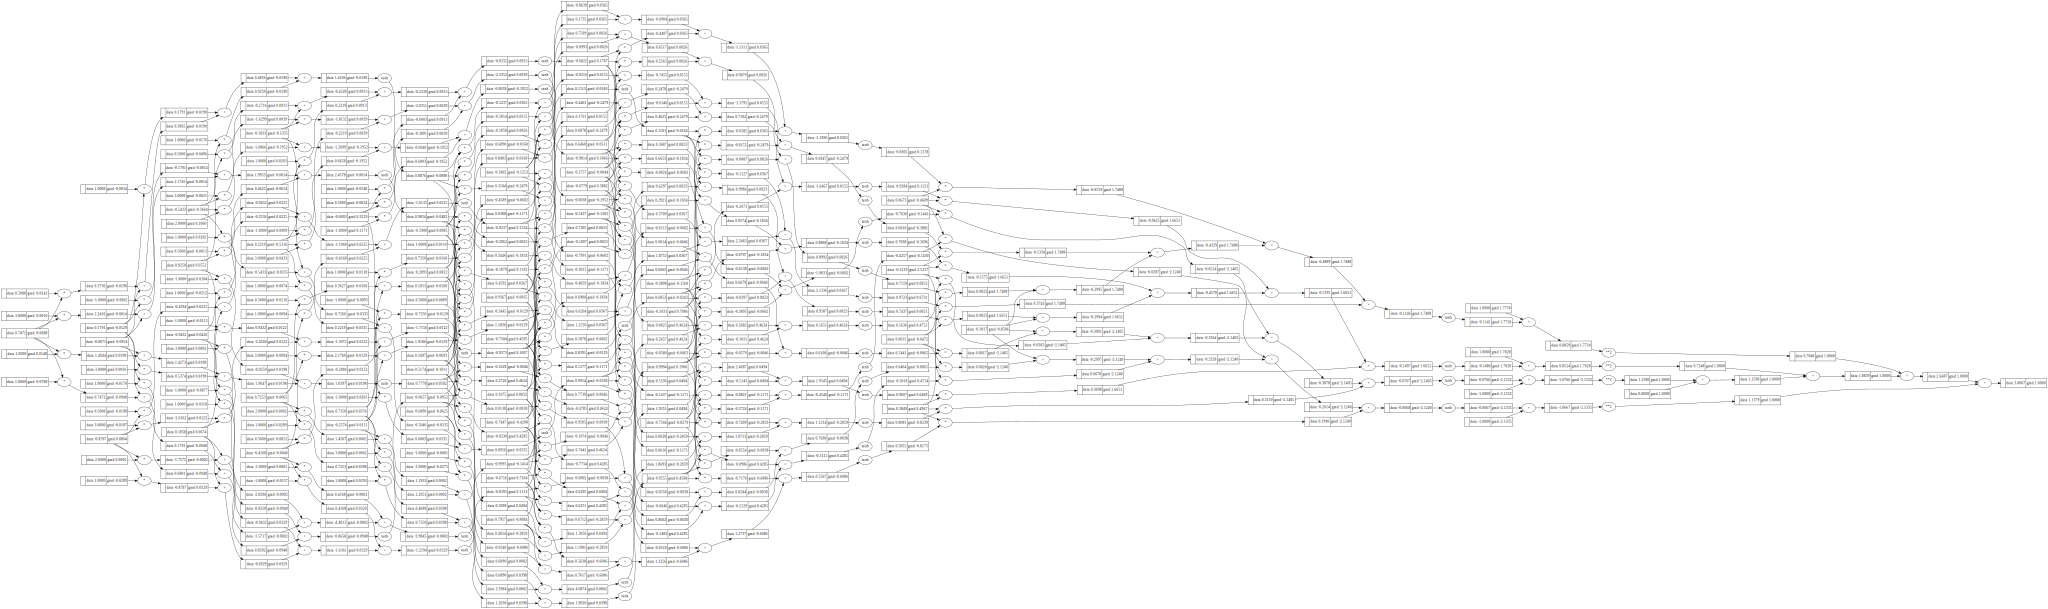

In [201]:
draw_dot(loss)